In [1]:
from glotaran_tools.specification_parser import parse_yml
from glotaran_core.model import Dataset
from glotaran_models.kinetic import KineticSeperableModel
import numpy as np
from lmfit import Parameters
# Imports for plotting

import matplotlib.pyplot as plt
%matplotlib notebook

fitspec = '''
type: kinetic

parameter: {}

compartments: [s1, s2, s3]

megacomplexes:
    - label: mc1
      k_matrices: [k1]

k_matrices:
  - label: "k1"
    matrix: {{
      '("s1","s1")': 1,
      '("s2","s2")': 2,
      '("s3","s3")': 3,
}}

initial_concentrations: []

irf:
  - label: irf1
    type: gaussian
    center: 4
    width: 5

datasets: 
  - label: dataset1
    type: spectral
    megacomplexes: [mc1]
    path: none
    irf: irf1

'''
   

In [2]:
test_parameter = [101e-4, 202e-5, 505e-6, 0.5, 10]
test_amps = [7, 3, 30]
test_x = np.arange(12820, 15120, 4.6)
times = np.asarray(np.arange(-100, 500, 1.5))
simparams = Parameters()
simparams.add("p1", 101e-3)
simparams.add("p2",202e-4)
simparams.add("p3",505e-5)
simparams.add("p4",0.1)
simparams.add("p5",30)
simparams.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr
p1     0.101     -inf      inf     None     True     None
p2    0.0202     -inf      inf     None     True     None
p3   0.00505     -inf      inf     None     True     None
p4       0.1     -inf      inf     None     True     None
p5        30     -inf      inf     None     True     None


In [3]:
model = parse_yml(fitspec.format(test_parameter))
print(model)

Modeltype: Kinetic

Parameter
---------

Index: 1 Initial Value: 0.0101 Label: None
Index: 2 Initial Value: 0.00202 Label: None
Index: 3 Initial Value: 0.000505 Label: None
Index: 4 Initial Value: 0.5 Label: None
Index: 5 Initial Value: 10.0 Label: None

Megacomplexes
-------------

Label: mc1
K-Matrices: ['k1']

Datasets
--------

Dataset 'dataset1'

	Dataset Scaling: None
	Initial Concentration: None
	Megacomplexes: ['mc1']

	Irf: irf1


K-Matrices
----------

Label: k1
Matrix:
[[3 0 0]
 [0 2 0]
 [0 0 1]]


IRFs
----

Label: irf1 Type: 'Gaussian' Center: [4] Width: [5] Center Dispersion: [] Width Dispersion [] Scale: [], Nomalize: True



In [4]:
fitmodel = KineticSeperableModel(model)

[]
(400, 501)
(400, 501)
(501,)


<IPython.core.display.Javascript object>


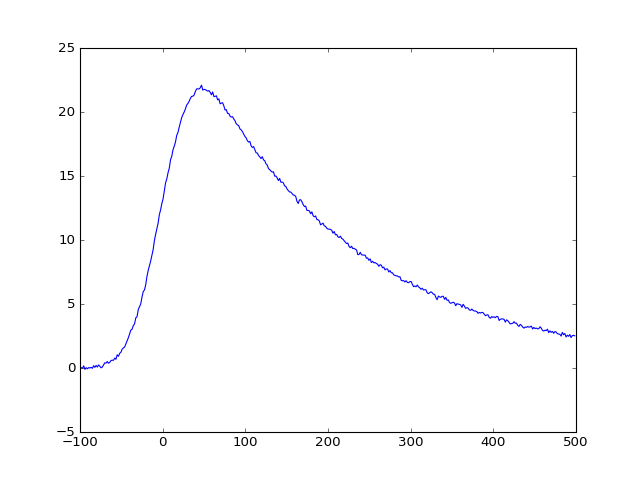

<IPython.core.display.Javascript object>


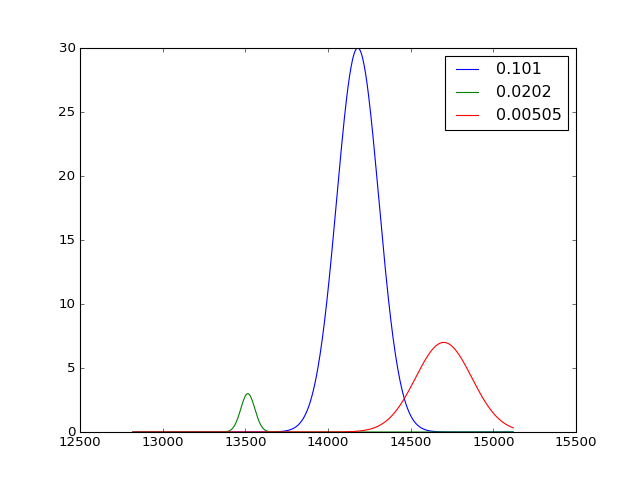

In [5]:
data = fitmodel.eval(simparams, *times, **{'dataset':'dataset1', 
                                           'noise':True, 'noise_std_dev':0.1,
                                           'dataset1_x': test_x,
                                           'amplitudes':test_amps,
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
# DAS
DAS = fitmodel.e_matrix(**{'dataset':'dataset1','dataset1_x': test_x,
                                           'amplitudes':test_amps,
                                          'locations':[14700, 13515, 14180],
                                           'delta': [400,100,300]
                                           })
print(data.shape)
print(test_x.shape)
fig = plt.figure()
plt.plot(times, data[:, 300])

fig = plt.figure()
d1, = plt.plot(test_x, DAS[:, 0], label=simparams['p1'].value)
d2, = plt.plot(test_x, DAS[:, 1], label=simparams['p2'].value)
d3, = plt.plot(test_x, DAS[:, 2], label=simparams['p3'].value)
plt.legend(handles=[d1, d2, d3])

<IPython.core.display.Javascript object>


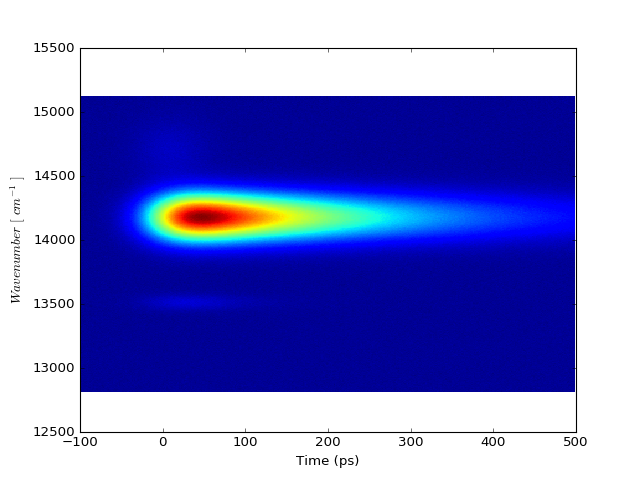

In [6]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, data.T)
plt.show()

In [9]:
result = fitmodel.fit(fitmodel.get_initial_fitting_parameter(), 
                      *times, 
                      **{"dataset1": data}
                     )
result.best_fit_parameter.pretty_print()
reconstructed_data = result.eval(*times, **{"dataset1": data})


[]
[]
[]
[]
[]
[]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7879e+04                                    1.05e+06    
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
       1              7         2.5455e+04      2.42e+03       9.70e-03       8.93e+05    
[]
[]
[]
[]
[]
[]
       2              8         2.5442e+04      1.31e+01       9.70e-03       2.29e+06    
[]
[]
[]
[]
[]
[]
       3              9         2.3757e+04      1.69e+03       2.42e-03       4.02e+04    
[]
[]
[]
[]
[]
[]
       4             10         2.3707e+04      4.99e+01       4.85e-03       1.11e+05    
[]
[]
[]
[]
[]
[]
[]
       5             12         2.3688e+04      1.91e+01       2.42e-03       7.20e+04    
[]
[]
[]
[]
[]
[]
[]
       6             14         2.3676e+04      1.21e+01       1.21e-03       3.18e+04    
[]
[]
[]
[]
[]
[]
       7             15         2.3666e+04      1.00e+01       2.42e-03       6.07e+04    
[]
[]
[]
[]
[]
[

<IPython.core.display.Javascript object>


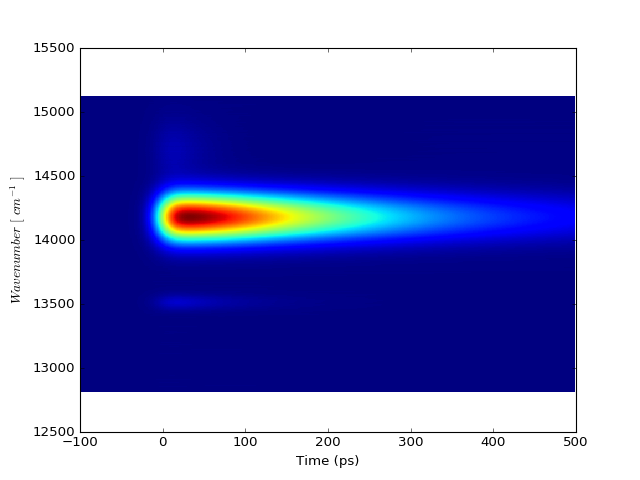

In [10]:
# Plot full trace

fig = plt.figure()
plt.xlabel('Time (ps)')
plt.ylabel('$Wavenumber\ [\ cm^{-1}\ ]$')
plt.pcolormesh(times, test_x, reconstructed_data.T)
plt.show()

In [11]:
# DAS
DAS = result.coefficients(*times, **{'dataset':'dataset1', "data": data})
print(DAS.shape)
fig = plt.figure()
d1, = plt.plot(test_x, DAS[0, :], label=result.best_fit_parameter['p1'].value)
d2, = plt.plot(test_x, DAS[1, :], label=result.best_fit_parameter['p2'].value)
d3, = plt.plot(test_x, DAS[2, :], label=result.best_fit_parameter['p3'].value)
plt.legend(handles=[d1, d2, d3])



KeyError: 'dataset1'

In [ ]:
data.shape